# 06 Explainability & Summary

This notebook consolidates results:
- Loads **response curves** and **optimal spends** (Part-3 & Part-5).
- Computes **Marginal ROI** at the optimized allocation (Conversions objective).
- Compares **Equal vs Optimized** (Conversions + Deduped Reach).
- Produces **executive visuals** saved to `../assets/` and summary CSVs to `../data/processed/`.

> Run after Parts 3, 4, and 5.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.interpolate import PchipInterpolator

# Paths
DATA_DIR   = Path("../data/processed")
RAW_DIR    = Path("../data/raw")
ASSETS_DIR = Path("../assets")
ASSETS_DIR.mkdir(parents=True, exist_ok=True)

plt.rcParams["figure.dpi"] = 140
plt.style.use("seaborn-v0_8-whitegrid")

print("Paths ready:", DATA_DIR.resolve(), ASSETS_DIR.resolve())

Paths ready: /Users/aravindanisetti/Desktop/2025 Training/Projects/oneplan-media-mix/data/processed /Users/aravindanisetti/Desktop/2025 Training/Projects/oneplan-media-mix/assets


In [35]:
# Map file names -> canonical channel names (consistent with Part-5 & README)
fname_map = {
    "LinearTV":  "lineartv_response_curve.csv",
    "Streaming": "streaming_response_curve.csv",
    "YouTube":   "youtube_response_curve.csv",
    "Display":   "display_response_curve.csv",
    "Social":    "social_response_curve.csv",
}

def load_curve(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df.drop(columns=[c for c in df.columns if str(c).lower().startswith("unnamed")], errors="ignore")
    # prefer boosted column, fallback to LR, then any numeric not 'spend'
    pred_cols = [c for c in df.columns if c.startswith("pred_conversions")]
    boosted = [c for c in pred_cols if "xgb" in c.lower()]
    if boosted:
        col = boosted[0]
    elif "pred_conversions_lr" in df.columns:
        col = "pred_conversions_lr"
    else:
        nc = [c for c in df.select_dtypes(include=[np.number]).columns if c != "spend"]
        if not nc:
            raise ValueError(f"No prediction-like column in {path.name}")
        col = nc[0]
    out = df[["spend", col]].rename(columns={col: "pred_conversions"}).dropna()
    out = out.sort_values("spend").drop_duplicates(subset=["spend"])
    if len(out) < 3:
        raise ValueError(f"{path.name}: need >=3 rows for stable interpolation")
    return out

CURVE_DIR = DATA_DIR / "response_curves"
curves = {}
missing_files = []

for ch, fn in fname_map.items():
    p = CURVE_DIR / fn
    if p.exists():
        try:
            curves[ch] = load_curve(p)
        except Exception as e:
            print(f"Skipping {ch} ({fn}): {e}")
    else:
        missing_files.append((ch, fn))

print("Loaded curves for:", list(curves.keys()))
if missing_files:
    print("Missing curve files:", missing_files)

# Build monotone, clamped conversion functions + spend bounds
conv_funcs = {}
spend_bounds = {}
for ch, dfc in curves.items():
    s = dfc["spend"].values
    y = dfc["pred_conversions"].values
    smin, smax = float(s.min()), float(s.max())
    spend_bounds[ch] = (smin, smax)
    pchip = PchipInterpolator(s, y, extrapolate=False)
    def f(xx, p=pchip, lo=y.min(), hi=y.max(), a=smin, b=smax):
        xx = np.atleast_1d(np.asarray(xx, dtype=float))
        yy = np.empty_like(xx, dtype=float)
        mask = (xx >= a) & (xx <= b)
        yy[mask] = p(xx[mask])
        yy[~mask & (xx < a)] = lo
        yy[~mask & (xx > b)] = hi
        return yy
    conv_funcs[ch] = f

pd.DataFrame([(ch, *spend_bounds[ch]) for ch in curves.keys()],
             columns=["channel","spend_min","spend_max"])

Loaded curves for: ['LinearTV', 'Streaming', 'YouTube', 'Display', 'Social']


,channel,spend_min,spend_max
0,LinearTV,12443.613962,118893.565597
1,Streaming,14376.663412,65797.093377
2,YouTube,6622.571033,41174.431085
3,Display,3087.360701,24827.974091
4,Social,3487.480676,20754.520665


In [36]:
# Optimal spends from Part-5
opt_conv_path  = DATA_DIR / "optimal_spend_conversions.csv"
opt_reach_path = DATA_DIR / "optimal_spend_reach.csv"
summary_p5_path = DATA_DIR / "part5_equal_vs_optimized_summary.csv"

opt_conv  = pd.read_csv(opt_conv_path)
opt_reach = pd.read_csv(opt_reach_path)
summary_p5 = pd.read_csv(summary_p5_path)

# Canonical dicts
opt_spend_conv  = dict(zip(opt_conv["channel"],  opt_conv["optimal_spend_conversions"]))
opt_spend_reach = dict(zip(opt_reach["channel"], opt_reach["optimal_spend_reach"]))

# Use only channels we have curves for AND optimized spends for
channels_use = [ch for ch in opt_spend_conv.keys() if ch in curves]
print("Channels used:", channels_use)
summary_p5

Channels used: ['LinearTV', 'Streaming', 'YouTube', 'Display', 'Social']


,metric,equal_split,optimized,lift_%
0,conversions,111.922161,121.427416,8.492737
1,deduped_reach_fraction,0.610925,0.458474,-24.954071
2,deduped_reach_people,610924.901353,458474.265724,-24.954071


,channel,opt_spend,marginal_roi_per_dollar
1,Streaming,40111.508530,0.002057
2,YouTube,21901.707391,0.001556
0,LinearTV,66111.350306,0.000721
3,Display,14007.583709,0.000460
4,Social,13733.716768,-0.000637


Saved: ../assets/p6_marginal_roi.png


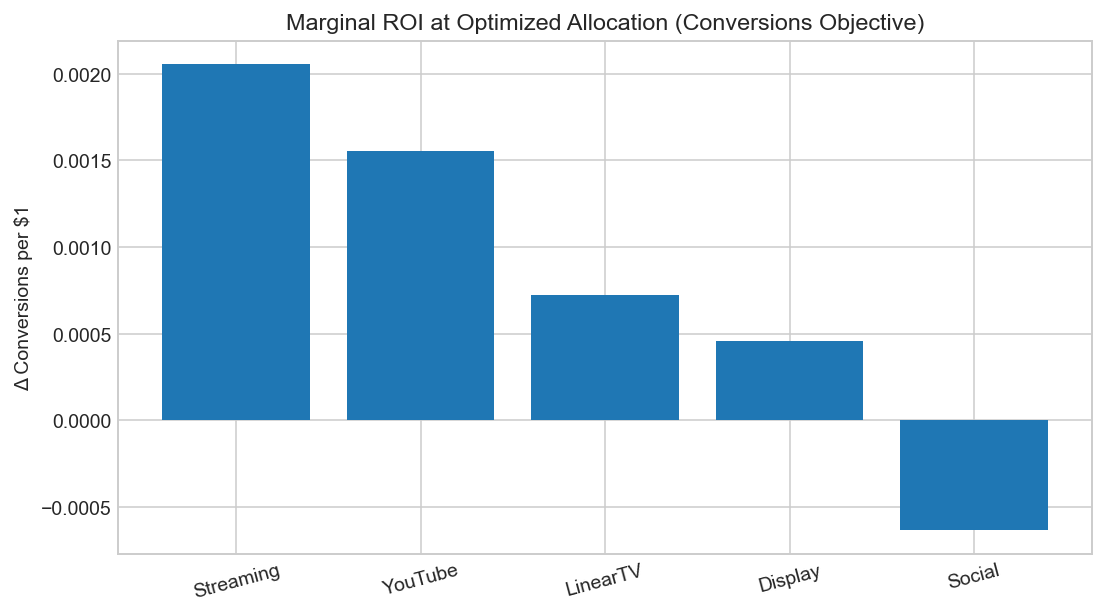

In [37]:
def marginal_roi(fn, s, smin, smax):
    """Finite-difference slope around s; adaptive step within [smin, smax]."""
    span = max(1.0, smax - smin)
    h = max(500.0, 0.01 * span)
    s2, s1 = min(s + h, smax), max(s - h, smin)
    if s2 == s1:
        return 0.0
    y2 = float(fn([s2])[0]); y1 = float(fn([s1])[0])
    return (y2 - y1) / (s2 - s1)

rows = []
for ch in channels_use:
    smin, smax = spend_bounds[ch]
    s_star = float(opt_spend_conv[ch])
    roi = marginal_roi(conv_funcs[ch], s_star, smin, smax)
    rows.append([ch, s_star, roi])

mroi_df = pd.DataFrame(rows, columns=["channel","opt_spend","marginal_roi_per_dollar"]) \
          .sort_values("marginal_roi_per_dollar", ascending=False)
display(mroi_df)

plt.figure(figsize=(8,4.5))
plt.bar(mroi_df["channel"], mroi_df["marginal_roi_per_dollar"])
plt.title("Marginal ROI at Optimized Allocation (Conversions Objective)")
plt.ylabel("Δ Conversions per $1")
plt.xticks(rotation=15)
plt.tight_layout()
png_mroi = ASSETS_DIR / "p6_marginal_roi.png"
plt.savefig(png_mroi, dpi=140)
print("Saved:", png_mroi)
plt.show()

mroi_df.to_csv(DATA_DIR / "marginal_roi_summary.csv", index=False)

Saved: ../assets/p6_opt_spend_conversions.png


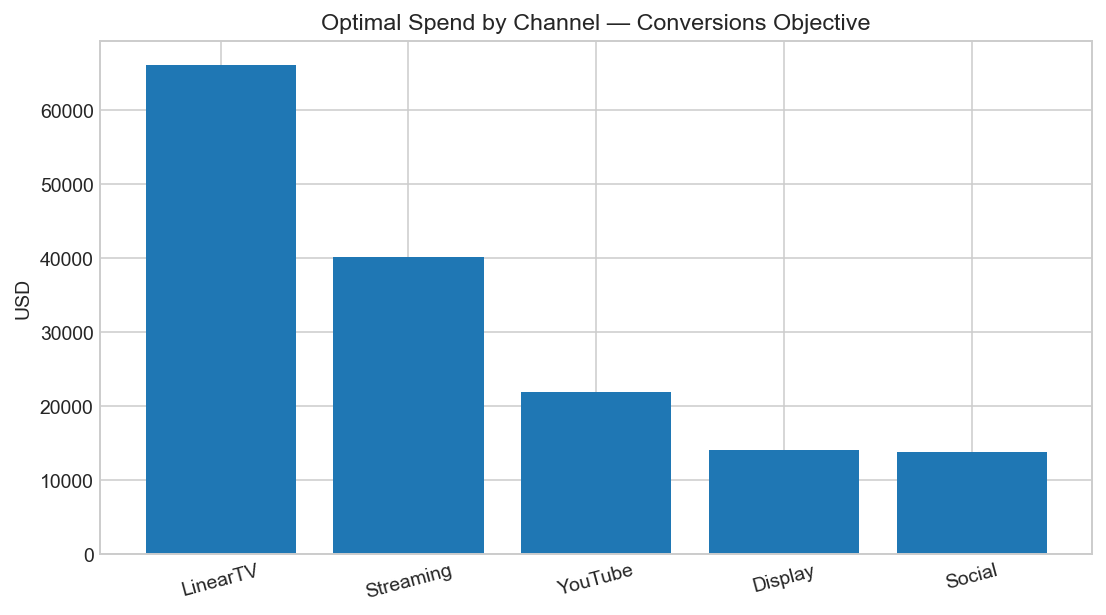

In [38]:
# Use channels_use to keep order consistent and avoid missing keys
alloc_conv = pd.DataFrame({
    "channel": channels_use,
    "optimal_spend_conversions": [opt_spend_conv[ch] for ch in channels_use]
})
alloc_conv = alloc_conv.sort_values("optimal_spend_conversions", ascending=False)

plt.figure(figsize=(8,4.5))
plt.bar(alloc_conv["channel"], alloc_conv["optimal_spend_conversions"])
plt.title("Optimal Spend by Channel — Conversions Objective")
plt.ylabel("USD")
plt.xticks(rotation=15)
plt.tight_layout()
png_alloc_conv = ASSETS_DIR / "p6_opt_spend_conversions.png"
plt.savefig(png_alloc_conv, dpi=140)
print("Saved:", png_alloc_conv)
plt.show()

Saved: ../assets/p6_opt_spend_reach.png


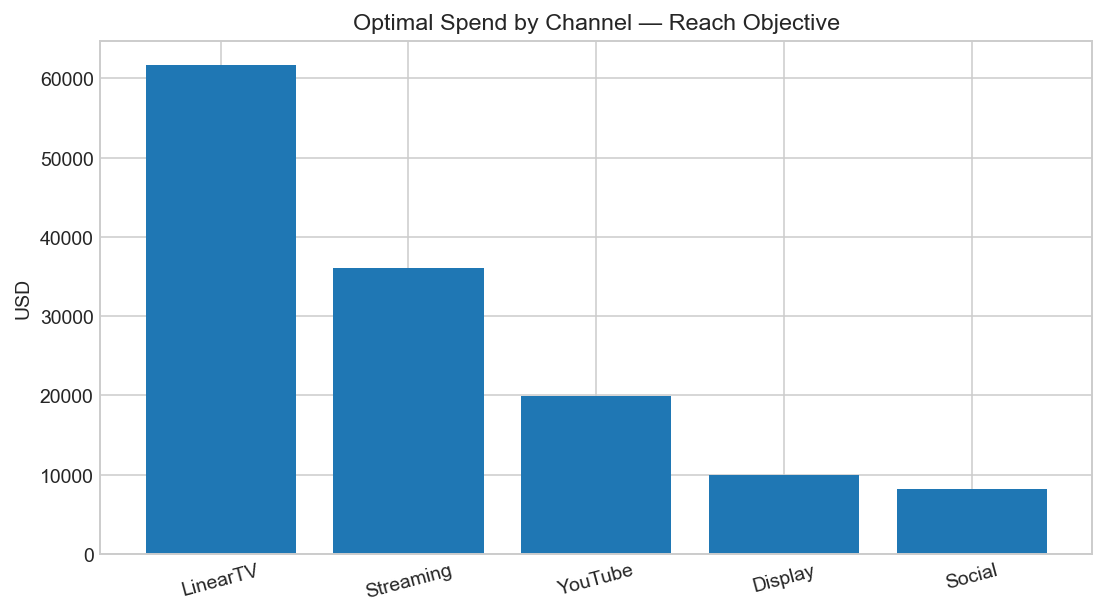

In [39]:
alloc_reach = pd.DataFrame({
    "channel": list(opt_spend_reach.keys()),
    "optimal_spend_reach": list(opt_spend_reach.values())
}).sort_values("optimal_spend_reach", ascending=False)

plt.figure(figsize=(8,4.5))
plt.bar(alloc_reach["channel"], alloc_reach["optimal_spend_reach"])
plt.title("Optimal Spend by Channel — Reach Objective")
plt.ylabel("USD")
plt.xticks(rotation=15)
plt.tight_layout()
png_alloc_reach = ASSETS_DIR / "p6_opt_spend_reach.png"
plt.savefig(png_alloc_reach, dpi=140)
print("Saved:", png_alloc_reach)
plt.show()

Saved: ../assets/p6_equal_vs_opt_conversions.png


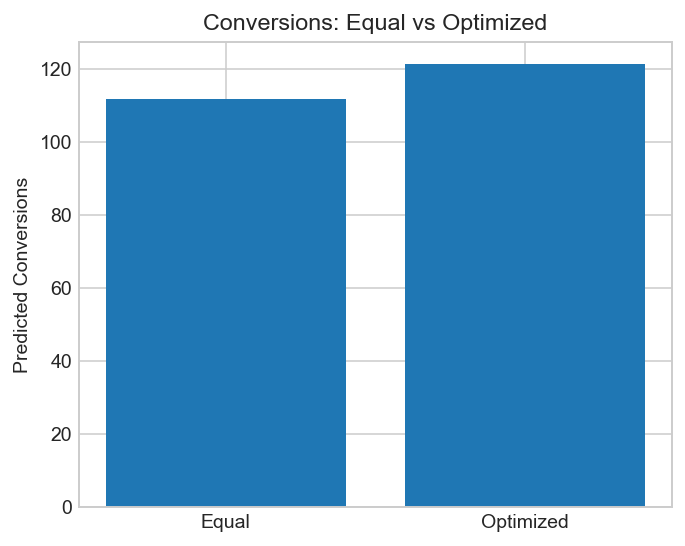

Saved: ../assets/p6_equal_vs_opt_reach.png


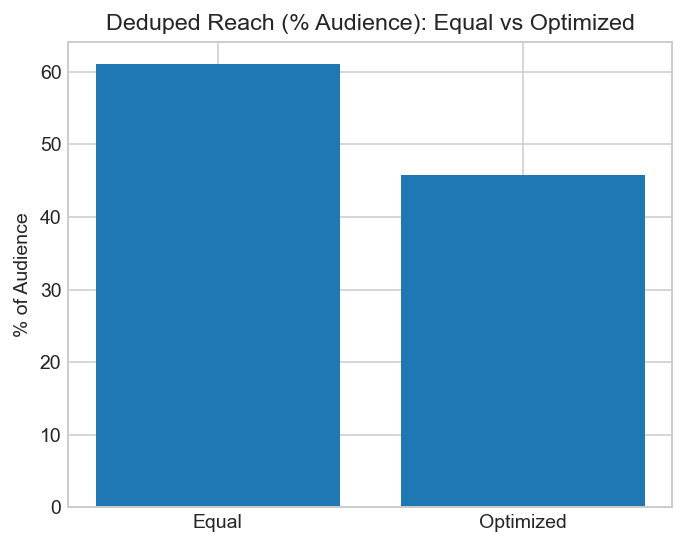

,metric,equal_split,optimized,lift_%
0,conversions,111.922161,121.427416,8.49
1,deduped_reach_fraction,0.610925,0.458474,-24.95
2,deduped_reach_people,610924.901353,458474.265724,-24.95


In [40]:
# Expect summary_p5 rows:
# 0 -> conversions, 1 -> deduped_reach_fraction, 2 -> deduped_reach_people
summary_disp = summary_p5.copy()
summary_disp["equal_split"] = summary_disp["equal_split"].astype(float)
summary_disp["optimized"]   = summary_disp["optimized"].astype(float)
summary_disp["lift_%"]      = summary_disp["lift_%"].astype(float).round(2)

# Conversions bars
plt.figure(figsize=(5,4))
plt.bar(["Equal", "Optimized"], summary_disp.loc[0, ["equal_split","optimized"]])
plt.title("Conversions: Equal vs Optimized")
plt.ylabel("Predicted Conversions")
plt.tight_layout()
png_eqopt_conv = ASSETS_DIR / "p6_equal_vs_opt_conversions.png"
plt.savefig(png_eqopt_conv, dpi=140)
print("Saved:", png_eqopt_conv)
plt.show()

# Reach bars (fraction → %)
plt.figure(figsize=(5,4))
plt.bar(["Equal", "Optimized"], summary_disp.loc[1, ["equal_split","optimized"]] * 100.0)
plt.title("Deduped Reach (% Audience): Equal vs Optimized")
plt.ylabel("% of Audience")
plt.tight_layout()
png_eqopt_reach = ASSETS_DIR / "p6_equal_vs_opt_reach.png"
plt.savefig(png_eqopt_reach, dpi=140)
print("Saved:", png_eqopt_reach)
plt.show()

summary_disp.to_csv(DATA_DIR / "part6_equal_vs_optimized_summary.csv", index=False)
display(summary_disp)

Saved: ../assets/p6_curve_lineartv.png


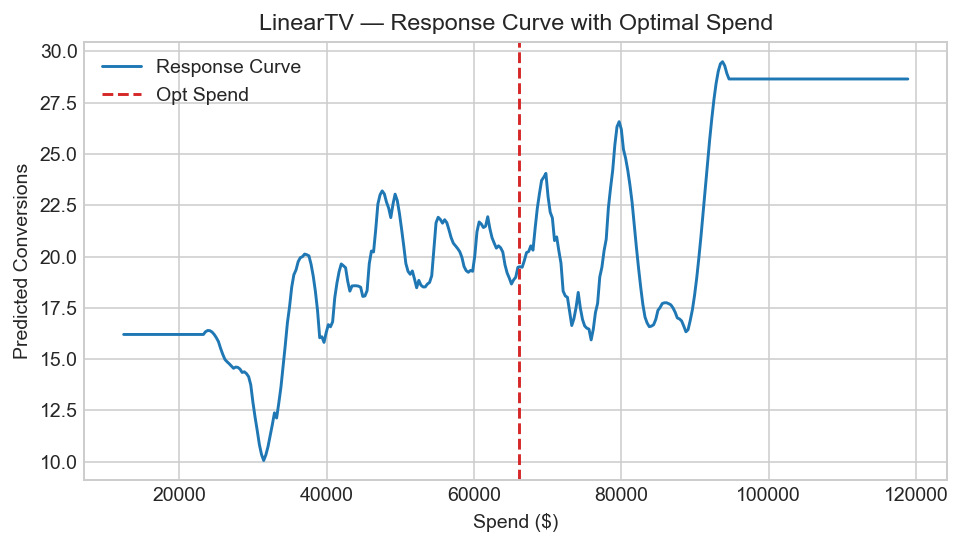

Saved: ../assets/p6_curve_streaming.png


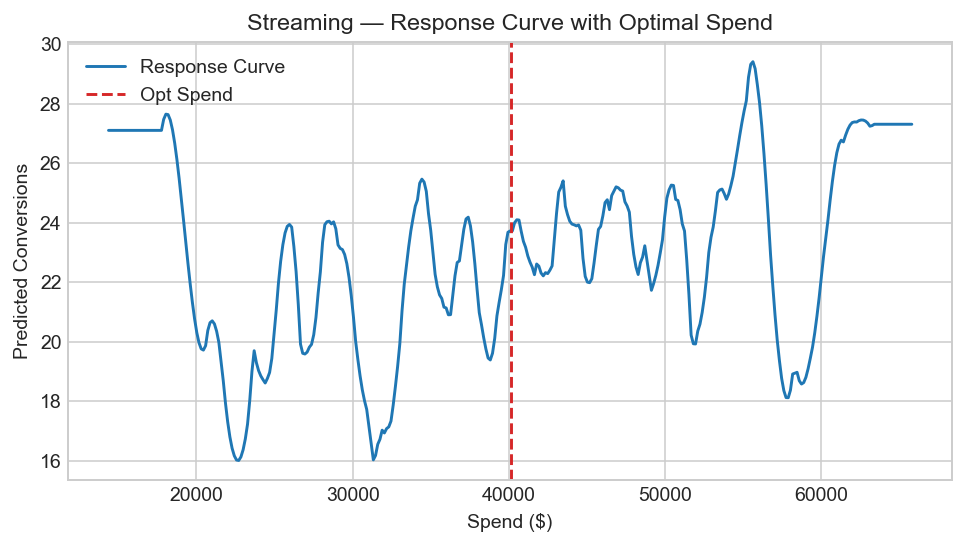

Saved: ../assets/p6_curve_youtube.png


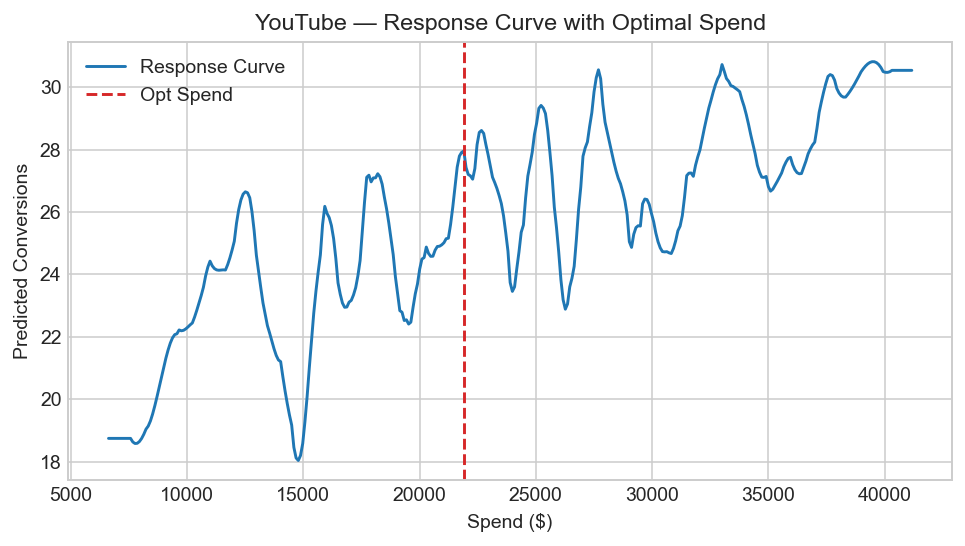

Saved: ../assets/p6_curve_display.png


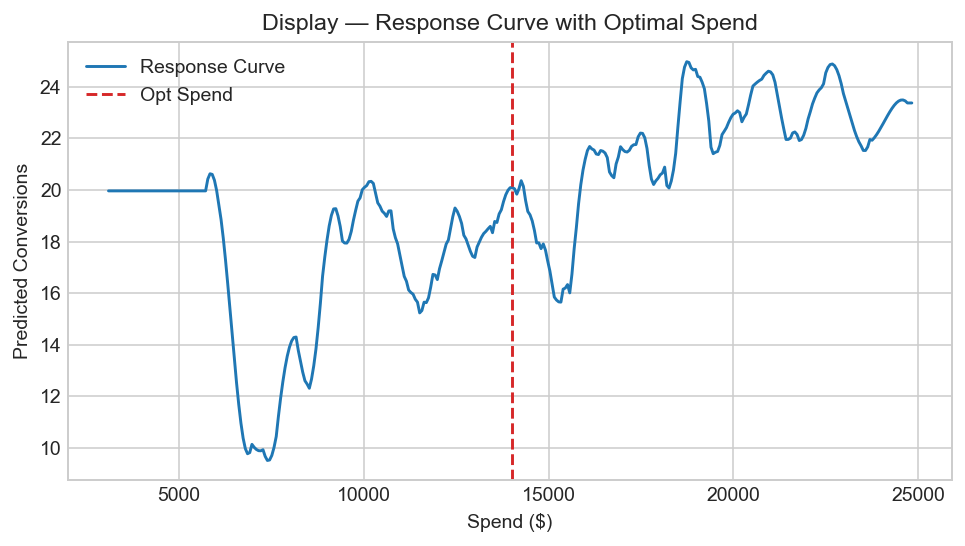

Saved: ../assets/p6_curve_social.png


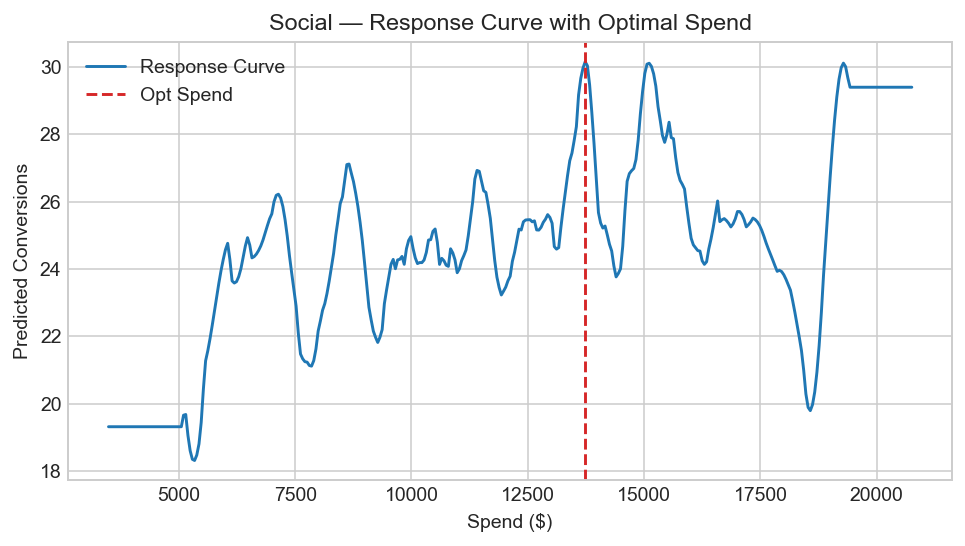

In [41]:
for ch in channels_use:
    dfc = curves[ch]
    s = dfc["spend"].values
    y = dfc["pred_conversions"].values
    smin, smax = s.min(), s.max()
    s_star = float(opt_spend_conv[ch])

    plt.figure(figsize=(7,4))
    plt.plot(s, y, label="Response Curve")
    plt.axvline(s_star, color="C3", linestyle="--", label="Opt Spend")
    plt.title(f"{ch} — Response Curve with Optimal Spend")
    plt.xlabel("Spend ($)")
    plt.ylabel("Predicted Conversions")
    plt.legend()
    plt.tight_layout()
    out = ASSETS_DIR / f"p6_curve_{ch.lower().replace(' ','').replace('-','')}.png"
    plt.savefig(out, dpi=140)
    print("Saved:", out)
    plt.show()

In [42]:
# Build a tiny executive Markdown summary you can link in README
sum_conv = summary_disp.loc[0]
sum_reach = summary_disp.loc[1]

md = f"""# OnePlan — Executive Summary (Part 6)

**Conversions:** equal={sum_conv['equal_split']:.2f}, optimized={sum_conv['optimized']:.2f}, lift=**{sum_conv['lift_%']:.2f}%**  
**Deduped Reach:** equal={sum_reach['equal_split']*100:.1f}%, optimized={sum_reach['optimized']*100:.1f}%, lift=**{sum_reach['lift_%']:.2f}%**

**Why the optimizer moved budget**  
- Channels with highest **marginal ROI** at the optimum: {", ".join(mroi_df.head(3)['channel'].tolist())}.
- Budget shifted toward these channels to maximize conversions.

**Figures**  
- `assets/{png_alloc_conv.name}`  
- `assets/{png_mroi.name}`  
- `assets/{png_eqopt_conv.name}`  
- `assets/{png_eqopt_reach.name}`
"""

REPORTS_DIR = Path("../reports")
REPORTS_DIR.mkdir(parents=True, exist_ok=True)
exec_md_path = REPORTS_DIR / "OnePlan_Executive_Summary.md"
with open(exec_md_path, "w") as f:
    f.write(md)

print("Writen to:", exec_md_path)


Writen to: ../reports/OnePlan_Executive_Summary.md


In [43]:
print("Assets in:", ASSETS_DIR.resolve())
print("Processed summaries in:", DATA_DIR.resolve())

Assets in: /Users/aravindanisetti/Desktop/2025 Training/Projects/oneplan-media-mix/assets
Processed summaries in: /Users/aravindanisetti/Desktop/2025 Training/Projects/oneplan-media-mix/data/processed
